# T81-558: Applications of Deep Neural Networks
**Class 5: Backpropagation.**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Common Functions from Before

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
# Plot a lift curve.  pred - the predictions, y - the expected output.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)

    plt.plot(t['y'].tolist(),label='expected')
    plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Classic Backpropagation
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $

This process is repeated for every iteration($t$).  How the weight change is calculated depends on the training algorithm.  Classic backpropagation simply calculates a gradient ($\nabla$) for every weight in the neural network with respect to the error function ($J$) of the neural network.  The gradient is scaled by a learning rate ($\eta$).

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) $

The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.

Gradients:

![Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv.png "Derivative")

The following link, from the book, shows how a simple [neural network is trained with backpropagation](http://www.heatonresearch.com/aifh/vol3/).

# Momentum Backpropagation

Momentum adds another term to the calculation of $v_t$:

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) + \lambda v_{t-1} $

Like the learning rate, momentum adds another training parameter that scales the effect of momentum.  Momentum backpropagation has two training parameters: learning rate ($\eta$) and momentum ($\lambda$).  Momentum simply adds the scaled value of the previous weight change amount ($v_{t-1}$) to the current weight change amount($v_t$).

This has the effect of adding additional force behind a direction a weight was moving.  This might allow the weight to escape a local minima:

![Momentum](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_momentum.png "Momentum")

A very common value for momentum is 0.9.


# Batch and Online Backpropagation

How often should the weights of a neural network be updated?  Gradients can be calculated for a training set element.  These gradients can also be summed together into batches and the weights updated once per batch.

* **Online Training** - Update the weights based on gradients calculated from a single training set element.
* **Batch Training** - Update the weights based on the sum of the gradients over all training set elements.
* **Batch Size** - Update the weights based on the sum of some batch size of training set elements.
* **Mini-Batch Training** - The same as batch size, but with a very small batch size.  Mini-batches are very popular and they are often in the 32-64 element range.

Because the batch size is smaller than the complete training set size, it may take several batches to make it completely through the training set.  You may have noticed TensorFlow reporting both steps and epochs when a neural network is trained:

```
Step #100, epoch #7, avg. train loss: 23.02969
Step #200, epoch #15, avg. train loss: 2.67576
Step #300, epoch #23, avg. train loss: 1.33839
Step #400, epoch #30, avg. train loss: 0.86830
Step #500, epoch #38, avg. train loss: 0.67166
Step #600, epoch #46, avg. train loss: 0.54569
Step #700, epoch #53, avg. train loss: 0.47544
Step #800, epoch #61, avg. train loss: 0.39358
Step #900, epoch #69, avg. train loss: 0.36052
```

* **Step/Iteration** - The number of batches that were processed.
* **Epoch** - The number of times the complete training set was processed.


# Stochastic Gradient Descent

Stochastic gradient descent (SGD) is currently one of the most popular neural network training algorithms.  It works very similarly to Batch/Mini-Batch training, except that the batches are made up of a random set of training elements.

This leads to a very irregular convergence in error during training:

![SGD Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_sgd_error.png "SGD Error")
[Image from Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Because the neural network is trained on a random sample of the complete training set each time, the error does not make a smooth transition downward.  However, the error usually does go down.

Advantages to SGD include:

* Computationally efficient.  Even with a very large training set, each training step can be relatively fast.
* Decreases overfitting by focusing on only a portion of the training set each step.


# Other Techniques

One problem with simple backpropagation training algorithms is that they are highly sensative to learning rate and momentum.  This is difficult because:

* Learning rate must be adjusted to a small enough level to train an accurate neural network.
* Momentum must be large enough to overcome local minima, yet small enough to not destabilize the training.
* A single learning rate/momentum is often not good enough for the entire training process. It is often useful to automatically decrease learning rate as the training progresses.
* All weights share a single learning rate/momentum.

Other training techniques:

* **Resilient Propagation** - Use only the magnitude of the gradient and allow each neuron to learn at its own rate.  No need for learning rate/momentum; however, only works in full batch mode.
* **Nesterov accelerated gradient** - Helps midigate the risk of choosing a bad mini-batch.
* **Adagrad** - Allows an automatically decaying per-weight learning rate and momentum concept.
* **Adadelta** - Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
* **Non-Gradient Methods** - Non-gradient methods can *sometimes* be useful, though rarely outperform gradient-based backpropagation methods.  These include: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization), [Nelder Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and [many more](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods).

# ADAM Update

ADAM is the first training algorithm you should try.  It is very effective.  Kingma and Ba (2014) introduced the Adam update rule that derives its name from the adaptive moment estimates that it uses.  Adam estimates the first (mean) and second (variance) moments to determine the weight corrections.  Adam begins with an exponentially decaying average of past gradients (m):

$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $

This average accomplishes a similar goal as classic momentum update; however, its value is calculated automatically based on the current gradient ($g_t$).  The update rule then calculates the second moment ($v_t$):

$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $

The values $m_t$ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.  However, they will have a strong bias towards zero in the initial training cycles.  The first moment’s bias is corrected as follows.

$ \hat{m}_t = \frac{m_t}{1-\beta^t_1} $

Similarly, the second moment is also corrected:

$ \hat{v}_t = \frac{v_t}{1-\beta_2^t} $

These bias-corrected first and second moment estimates are applied to the ultimate Adam update rule, as follows:

$ \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t}+\eta} \hat{m}_t $

Adam is very tolerant to initial learning rate (η) and other training parameters. Kingma and Ba (2014)  propose default values of 0.9 for $\beta_1$, 0.999 for $\beta_2$, and 10-8 for $\eta$.

# Methods Compared

The following image shows how each of these algorithms train (image credits: [author](Alec Radford), [where I found it](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")



# Specifying the Update Rule in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**



Step #50, epoch #5, avg. train loss: 20.34096, avg. val loss: 14.38684
Step #100, epoch #10, avg. train loss: 8.21658, avg. val loss: 7.30104
Step #150, epoch #15, avg. train loss: 6.48438, avg. val loss: 5.86963
Step #200, epoch #20, avg. train loss: 5.58166, avg. val loss: 5.14109
Step #250, epoch #25, avg. train loss: 4.89689, avg. val loss: 4.63683
Step #300, epoch #30, avg. train loss: 4.64199, avg. val loss: 4.25890
Step #350, epoch #35, avg. train loss: 4.39752, avg. val loss: 4.06373
Step #400, epoch #40, avg. train loss: 3.93127, avg. val loss: 3.76228
Step #450, epoch #45, avg. train loss: 3.74136, avg. val loss: 3.53878
Step #500, epoch #50, avg. train loss: 3.46492, avg. val loss: 3.32482
Step #550, epoch #55, avg. train loss: 3.28064, avg. val loss: 3.17043
Step #600, epoch #60, avg. train loss: 3.13331, avg. val loss: 3.03592
Step #650, epoch #65, avg. train loss: 3.01669, avg. val loss: 2.94601
Step #700, epoch #70, avg. train loss: 2.92124, avg. val loss: 2.85489
Step #

Stopping. Best step:
 step 907 with loss 1.4028416872024536


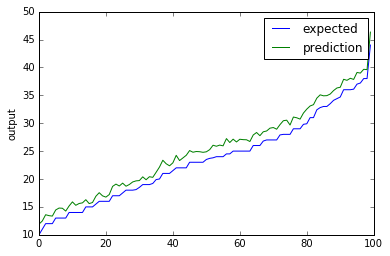

In [15]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
regressor = skflow.TensorFlowDNNRegressor(
    hidden_units=[50, 25, 10], 
    batch_size = 32,
    #momentum=0.9,
    optimizer='SGD', 
    learning_rate=0.01,  
    steps=5000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50)

# Fit/train neural network
regressor.fit(x_train, y_train, monitor=early_stop)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred,y_test)